<a href="https://colab.research.google.com/github/milagrosonofri/Problem_Set_1/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Obtención y limpieza de la base de datos

In [ ]:
# Importamos las librerías necesarias
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut

Web Scraping

In [ ]:
# Armamos una lista para almacenar todos los datos
data = []

# Base URL de las páginas
base_url = 'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html'

# Iteramos sobre las 10 páginas
for i in range(1, 11):

    # Construimos la URL de la página actual
    url = base_url.format(i)

    # Enviamos solicitud HTTP
    response = requests.get(url)
    print(f"Scraping página {i}: {response}")  # Confirmar que la solicitud es exitosa (<Response [200]>)

    # Parsear el contenido HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # Encontrar la tabla en la página
    table = soup.find('table')

    # Extraemos encabezados (solo en la primera iteración)
    if i == 1:  # Tomar encabezados solo de la primera página
        headers = []
        for header in table.find_all('th'):
            headers.append(header.text.strip())

    # Extraemos filas de datos
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('td'):
            row_data.append(cell.text.strip())
        if row_data:  # Agregar solo filas con datos
            data.append(row_data)

# Convertimos los datos consolidados en un DataFrame
df = pd.DataFrame(data, columns=headers)

df

Scraping página 1: <Response [200]>
Scraping página 2: <Response [200]>
Scraping página 3: <Response [200]>
Scraping página 4: <Response [200]>
Scraping página 5: <Response [200]>
Scraping página 6: <Response [200]>
Scraping página 7: <Response [200]>
Scraping página 8: <Response [200]>
Scraping página 9: <Response [200]>
Scraping página 10: <Response [200]>


,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
0,1,4514331,1,2,1,BOGOTA,1,2,0,29,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125
2,3,4514332,1,4,1,BOGOTA,1,2,1,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,4514332,1,3,1,BOGOTA,1,2,1,7,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,4514332,1,1,1,BOGOTA,1,2,0,32,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NA,NA,NA,3345.5556640625,NA,NA,NA,NA,1003666.6875,3345.5556640625
32173,3214,4804455,1,1,1,BOGOTA,12,3,0,36,...,5e+05,NA,NA,25958.333984375,NA,NA,NA,NA,6675000,25958.333984375
32174,3215,4804455,1,2,1,BOGOTA,12,3,1,41,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
32175,3216,4804455,1,3,1,BOGOTA,12,3,1,8,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Limpieza de base de datos

In [23]:
# Obtenmos el nombre de todas las variables disponibles
variables = df.columns.tolist()

print(variables)

# Restringimos a individuos empleados mayores de 18 años (HAY QUE REVISAR SI P6240 ES LA CORRECTA)
df_limpio = df[(df['age'].astype(float) > 18) & (df['ocu'] == '1')]

print(f"Número de registros después del filtro (empleados mayores de 18 años): {len(df_limpio)}")

['', 'directorio', 'secuencia_p', 'orden', 'clase', 'dominio', 'mes', 'estrato1', 'sex', 'age', 'p6050', 'p6090', 'p6100', 'p6210', 'p6210s1', 'p6240', 'oficio', 'p6426', 'relab', 'p6500', 'p6510', 'p6510s1', 'p6510s2', 'p6545', 'p6545s1', 'p6545s2', 'p6580', 'p6580s1', 'p6580s2', 'p6585s1', 'p6585s1a1', 'p6585s1a2', 'p6585s2', 'p6585s2a1', 'p6585s2a2', 'p6585s3', 'p6585s3a1', 'p6585s3a2', 'p6585s4', 'p6585s4a1', 'p6585s4a2', 'p6590', 'p6590s1', 'p6600', 'p6600s1', 'p6610', 'p6610s1', 'p6620', 'p6620s1', 'p6630s1', 'p6630s1a1', 'p6630s2', 'p6630s2a1', 'p6630s3', 'p6630s3a1', 'p6630s4', 'p6630s4a1', 'p6630s6', 'p6630s6a1', 'p6750', 'p6760', 'p550', 'hoursWorkUsual', 'p6870', 'p6920', 'p7040', 'hoursWorkActualSecondJob', 'p7050', 'p7070', 'p7090', 'p7110', 'p7120', 'p7140s1', 'p7140s2', 'p7150', 'p7160', 'p7310', 'p7350', 'p7422', 'p7422s1', 'p7472', 'p7472s1', 'p7495', 'p7500s1', 'p7500s1a1', 'p7500s2', 'p7500s2a1', 'p7500s3', 'p7500s3a1', 'p7505', 'p7510s1', 'p7510s1a1', 'p7510s2', 'p7

In [24]:
# Primer approach para describir los datos

print("Información del DataFrame:")
print(df_limpio.info())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 16397 entries, 1 to 32174
Columns: 178 entries,  to y_total_m_ha
dtypes: object(178)
memory usage: 22.4+ MB
None


In [25]:
# Renombramos variables para tener una interpretación mas sencilla de aquí en adelante
df_limpio = df_limpio.rename(columns={'p6500': 'salario_empleo_principal', 'p7070': 'salario_empleo_secundario',
                                      'p6426': 'antig', 'sex': 'sexo', 'age': 'edad'})

In [26]:
# Convertimos algunas variables de relacionados al salario horario a formato numérico para poder compararlas
wage_hours_related_vars = ['salario_empleo_principal', 'salario_empleo_secundario', 'hoursWorkUsual', 'hoursWorkActualSecondJob',
                           'y_salary_m', 'y_salary_m_hu', 'y_ingLab_m', 'y_ingLab_m_ha']

for col in wage_hours_related_vars:

    df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce')
    print(f"{col} dtype: {df_limpio[col].dtype}")

# Calculamos 'hour_wage' teniendo en cuenta los valores NaN
df_limpio['hour_wage'] = (df_limpio['salario_empleo_principal'].fillna(0) + df_limpio['salario_empleo_secundario'].fillna(0)) / \
                                         ((df_limpio['hoursWorkActualSecondJob'].fillna(0) + df_limpio['hoursWorkUsual'].fillna(0))*4)

# Ajustamos para casos donde el denominador es cero (para evitar divisiones por cero)
df_limpio.loc[(df_limpio['hoursWorkActualSecondJob'].fillna(0) + df_limpio['hoursWorkUsual'].fillna(0)) == 0, 'hour_wage'] = np.nan

# Ajustamos para casos donde ambos, salario_empleo_principal y salario_empleo_secundario, son NaN
df_limpio.loc[df_limpio['salario_empleo_principal'].isna() & df_limpio['salario_empleo_secundario'].isna(), 'hour_wage'] = np.nan

# Ajustamos para casos donde ambos, hoursWorkActualSecondJob y hoursWorkUsual, son NaN
df_limpio.loc[df_limpio['hoursWorkActualSecondJob'].isna() & df_limpio['hoursWorkUsual'].isna(), 'hour_wage'] = np.nan

# Agregamos la variable creada a la lista con las variables a comparar
wage_hours_related_vars = wage_hours_related_vars + ['hour_wage']

salario_empleo_principal dtype: float64
salario_empleo_secundario dtype: float64
hoursWorkUsual dtype: int64
hoursWorkActualSecondJob dtype: float64
y_salary_m dtype: float64
y_salary_m_hu dtype: float64
y_ingLab_m dtype: float64
y_ingLab_m_ha dtype: float64


In [27]:
# Observamos variables de interés
print("Unique values in 'maxEducLevel':")
print(df_limpio['maxEducLevel'].unique())

print("\nUnique values in 'sizeFirm':")
print(df_limpio['sizeFirm'].unique())

print("\nUnique values in 'relab':")
print(df_limpio['relab'].unique())

print("\nUnique values in 'informal':")
print(df_limpio['informal'].unique())

print("\nUnique values in 'sex':")
print(df_limpio['sexo'].unique())

print("\nUnique values in 'oficio':")
print(df_limpio['oficio'].unique())

Unique values in 'maxEducLevel':
['6' '7' '4' '3' '5' '1' 'NA']

Unique values in 'sizeFirm':
['5' '3' '2' '4' '1']

Unique values in 'relab':
['2' '1' '4' '5' '3' '6' '9' '7' '8']

Unique values in 'informal':
['0' '1']

Unique values in 'sex':
['1' '0']

Unique values in 'oficio':
['39' '85' '45' '53' '13' '42' '33' '37' '57' '84' '55' '79' '56' '93'
 '21' '98' '32' '97' '54' '95' '58' '30' '19' '83' '51' '18' '41' '2' '44'
 '81' '3' '92' '6' '38' '77' '11' '15' '8' '61' '90' '87' '91' '16' '59'
 '36' '5' '99' '12' '80' '17' '34' '7' '70' '9' '4' '62' '75' '73' '50'
 '31' '52' '60' '94' '72' '35' '82' '89' '88' '40' '1' '74' '63' '43' '86'
 '14' '49' '20' '96' '76' '78']


In [28]:
# Convertimos a las que van a ser mis variables independientes a tipo numérico, manejando posibles valores no numéricos (como 'NA')

df_limpio['maxEducLevel'] = pd.to_numeric(df_limpio['maxEducLevel'], errors='coerce')
df_limpio['antig'] = pd.to_numeric(df_limpio['antig'], errors='coerce')
df_limpio['edad'] = pd.to_numeric(df_limpio['edad'], errors='coerce')
df_limpio['sizeFirm'] = pd.to_numeric(df_limpio['sizeFirm'], errors='coerce')
df_limpio['relab'] = pd.to_numeric(df_limpio['relab'], errors='coerce')
df_limpio['informal'] = pd.to_numeric(df_limpio['informal'], errors='coerce')
df_limpio['sexo'] = pd.to_numeric(df_limpio['sexo'], errors='coerce')
df_limpio['oficio'] = pd.to_numeric(df_limpio['oficio'], errors='coerce')

In [29]:
# Diccionario de agrupaciones
agrupaciones = {
    "Ciencias, Ingeniería y Tecnología": [1, 2, 3, 4, 8],
    "Ciencias Biológicas y de la Salud": [5, 6, 7],
    "Ciencias Sociales y Humanidades": [9, 11, 12, 13, 19],
    "Arte, Cultura y Medios": [15, 16, 17, 18, 92],
    "Administración y Gestión": [20, 21, 30],
    "Oficios Administrativos y Comerciales": [31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 49],
    "Servicios Personales y Comunitarios": [14, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
    "Agricultura, Pesca y Explotación de Recursos Naturales": [60, 61, 62, 63, 64, 71, 72, 73],
    "Industria, Manufactura y Construcción": [70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96],
    "Transporte y Logística": [35, 36, 37, 97, 98],
    "Otros Oficios y Trabajos No Clasificados": [99]
}

# Función para asignar la nueva categoría
def asignar_categoria(codigo):
    for categoria, codigos in agrupaciones.items():
        if codigo in codigos:
            return categoria
    return "Sin Categoría"  # En caso de que algún código no esté clasificado

# Aplicamos la función a cada fila en la columna "oficio" para crear la nueva columna "oficio_new"
df_limpio['oficio_new'] = df_limpio['oficio'].apply(asignar_categoria)

In [30]:
print(df_limpio['oficio_new'].unique())

['Oficios Administrativos y Comerciales'
 'Industria, Manufactura y Construcción'
 'Servicios Personales y Comunitarios' 'Ciencias Sociales y Humanidades'
 'Transporte y Logística' 'Administración y Gestión'
 'Arte, Cultura y Medios' 'Ciencias, Ingeniería y Tecnología'
 'Ciencias Biológicas y de la Salud'
 'Agricultura, Pesca y Explotación de Recursos Naturales'
 'Otros Oficios y Trabajos No Clasificados']


In [31]:
# Generamos dummies para variables categóricas
categorical_vars = ["relab", "sizeFirm", "maxEducLevel", "oficio_new"]
df_encoded = pd.get_dummies(df_limpio, columns=categorical_vars, drop_first = True)

# Definimos un subset con las variables de interés con el format correcto
variables = ["y_ingLab_m_ha", "informal", "antig", "sexo", "edad"] + \
            [col for col in df_encoded.columns if any(var in col for var in categorical_vars)]

subset = df_encoded[variables]

In [ ]:
print(df_limpio)

            directorio secuencia_p orden clase dominio mes estrato1  sexo  \
1         2    4514331           1     1     1  BOGOTA   1        2     1   
8         9    4514333           1     1     1  BOGOTA   1        2     1   
13       14    4514334           1     1     1  BOGOTA   1        2     1   
15       16    4514335           1     1     1  BOGOTA   1        2     1   
21       22    4514338           1     2     1  BOGOTA   1        2     0   
...     ...        ...         ...   ...   ...     ...  ..      ...   ...   
32167  3208    4804453           1     9     1  BOGOTA  12        3     1   
32171  3212    4804454           1     1     1  BOGOTA  12        2     1   
32172  3213    4804454           1     2     1  BOGOTA  12        2     0   
32173  3214    4804455           1     1     1  BOGOTA  12        3     0   
32174  3215    4804455           1     2     1  BOGOTA  12        3     1   

       edad  ... y_salarySec_m y_ingLab_m_ha y_gananciaNeta_m  \
1        3

## Descripción de los datos

In [32]:
# Estadisticos descriptivos para asociadas al salario horario

pd.set_option('display.float_format', '{:,.2f}'.format)

for col in wage_hours_related_vars:

  print("\nEstadísticas descriptivas:")
  print(df_limpio[col].describe())

  zero_count = (df_limpio[col] == 0).sum()
  na_count = df_limpio[col].isna().sum()
  print(f"Number of zeros in '{col}': {zero_count}")
  print(f"Number of missing values (NA) in '{col}': {na_count}")


Estadísticas descriptivas:
count       10,441.00
mean     1,467,828.51
std      2,123,494.84
min              0.00
25%        781,242.00
50%        880,000.00
75%      1,400,000.00
max     34,000,000.00
Name: salario_empleo_principal, dtype: float64
Number of zeros in 'salario_empleo_principal': 656
Number of missing values (NA) in 'salario_empleo_principal': 5956

Estadísticas descriptivas:
count       16,366.00
mean        19,294.83
std        219,840.45
min              0.00
25%              0.00
50%              0.00
75%              0.00
max     10,000,000.00
Name: salario_empleo_secundario, dtype: float64
Number of zeros in 'salario_empleo_secundario': 15913
Number of missing values (NA) in 'salario_empleo_secundario': 31

Estadísticas descriptivas:
count   16,397.00
mean        47.05
std         15.50
min          1.00
25%         40.00
50%         48.00
75%         50.00
max        130.00
Name: hoursWorkUsual, dtype: float64
Number of zeros in 'hoursWorkUsual': 0
Number of mis

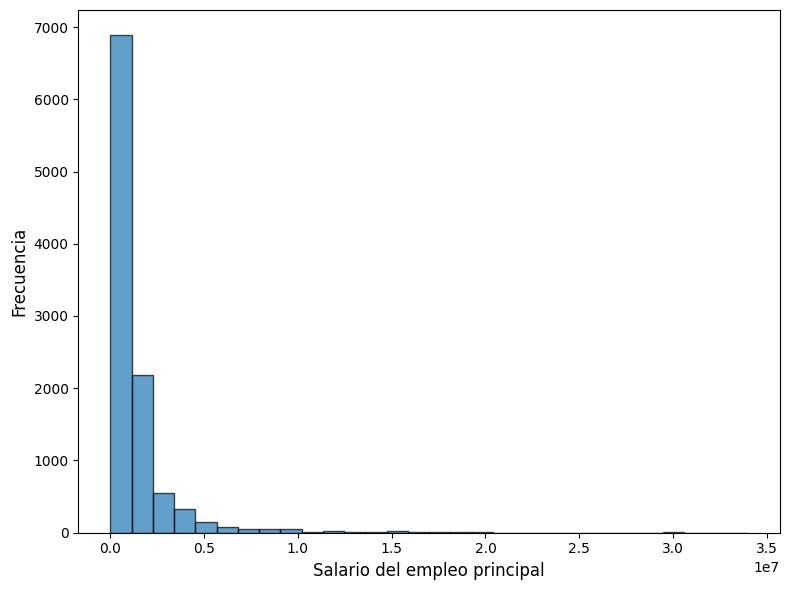

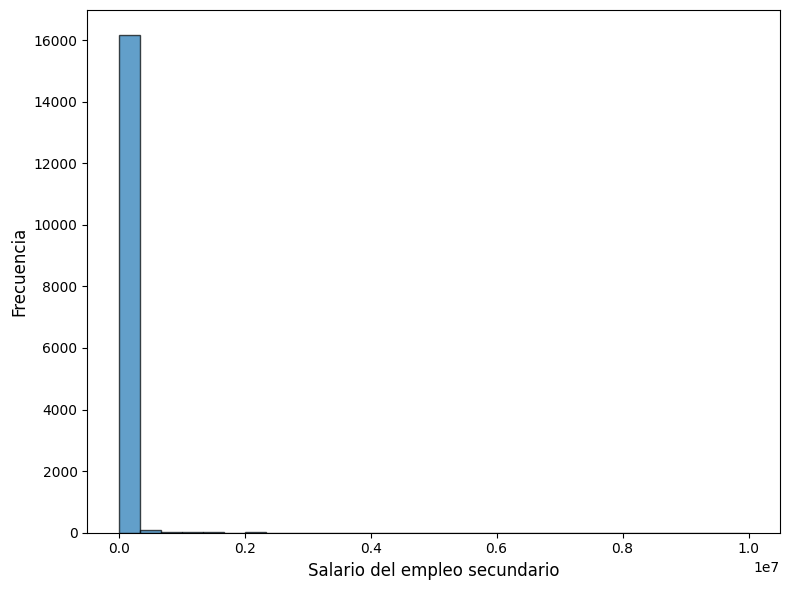

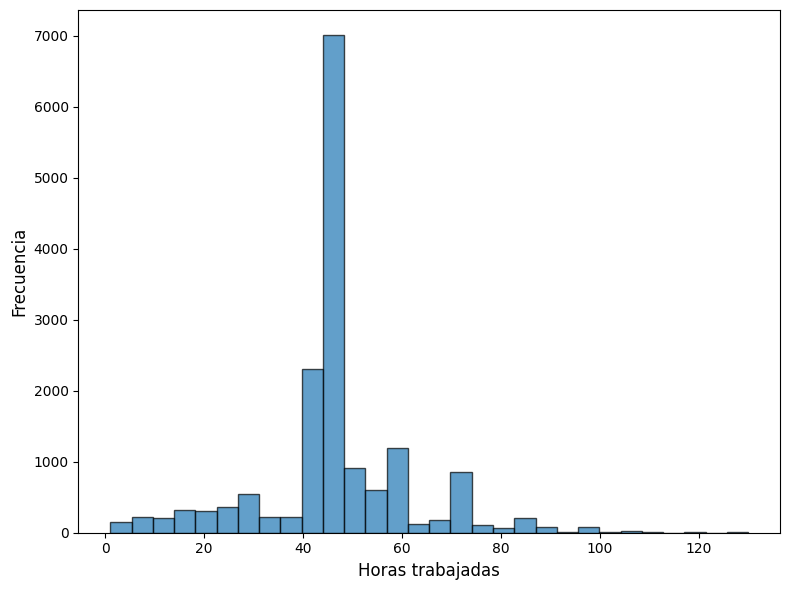

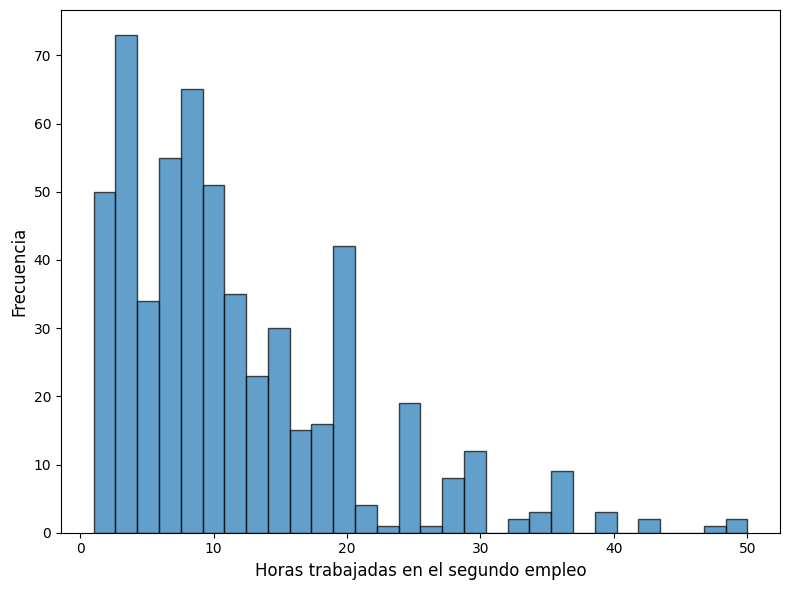

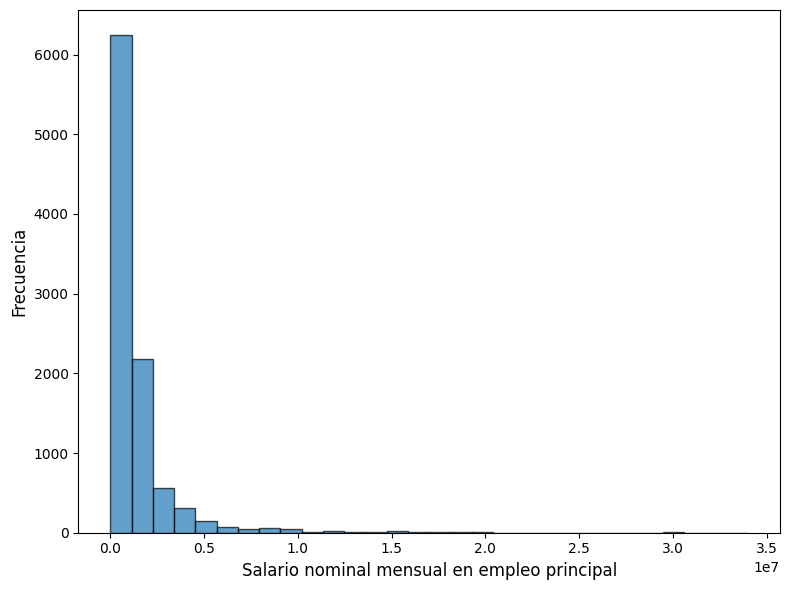

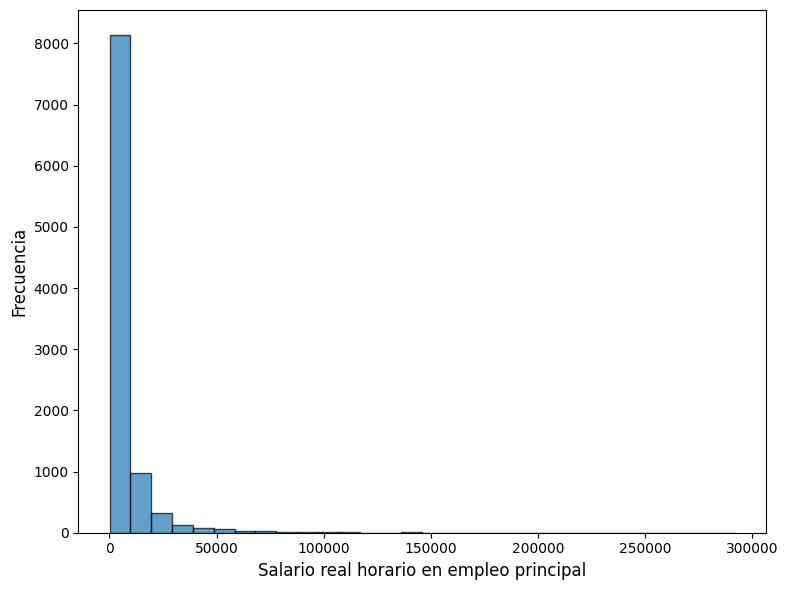

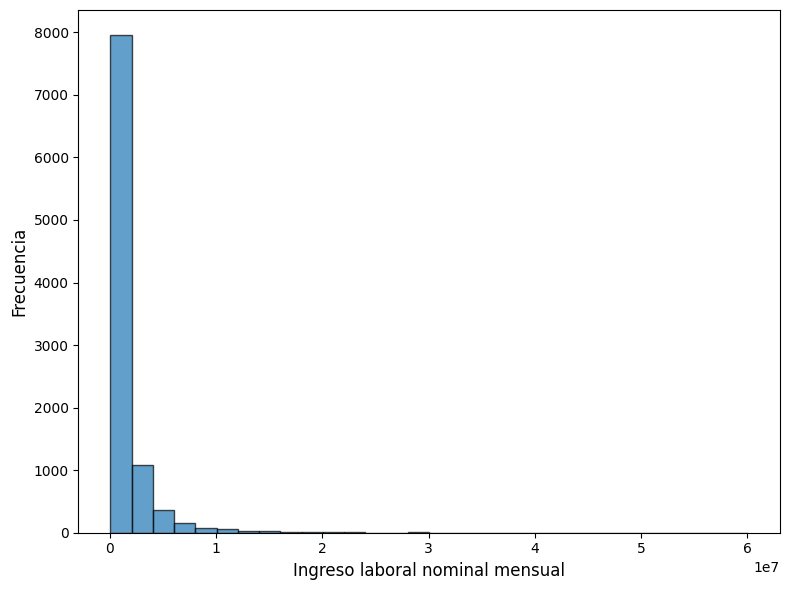

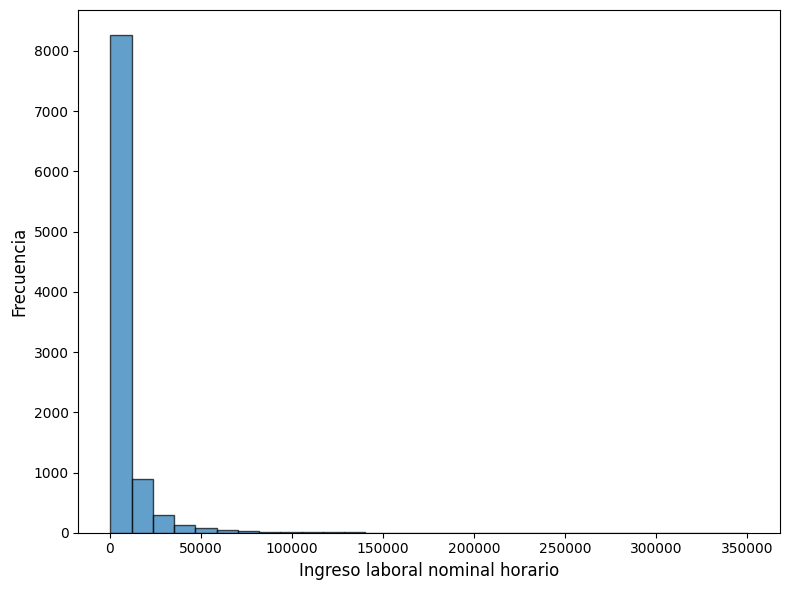

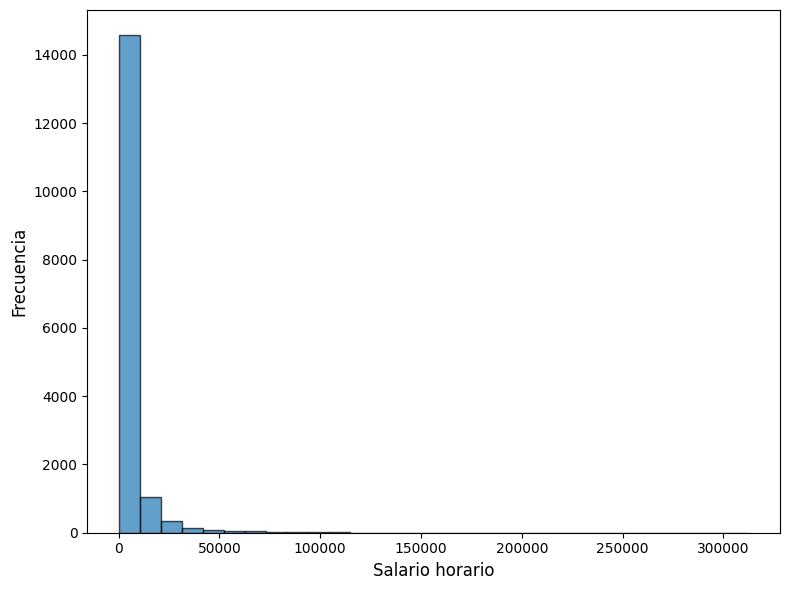

In [33]:
# Diccionario con nombres descriptivos para las variables
etiquetas = {
    "salario_empleo_principal": "Salario del empleo principal",
    "salario_empleo_secundario": "Salario del empleo secundario",
    "hoursWorkUsual": "Horas trabajadas",
    "hoursWorkActualSecondJob": "Horas trabajadas en el segundo empleo",
    "y_salary_m": "Salario nominal mensual en empleo principal",
    "y_salary_m_hu": "Salario real horario en empleo principal",
    "y_ingLab_m": "Ingreso laboral nominal mensual",
    "y_ingLab_m_ha": "Ingreso laboral nominal horario",
    "hour_wage": "Salario horario"
}


# Graficamos histogramas
for col in wage_hours_related_vars:
    data = df_limpio[col].dropna()

    plt.figure(figsize=(8, 6))  # Tamaño de la figura
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel(etiquetas.get(col, col), fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajusta los márgenes automáticamente
    plt.show()

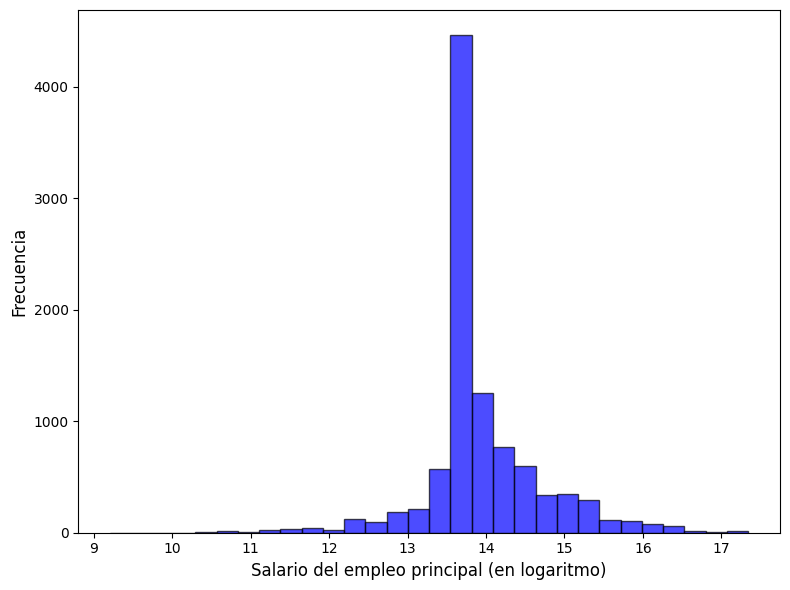

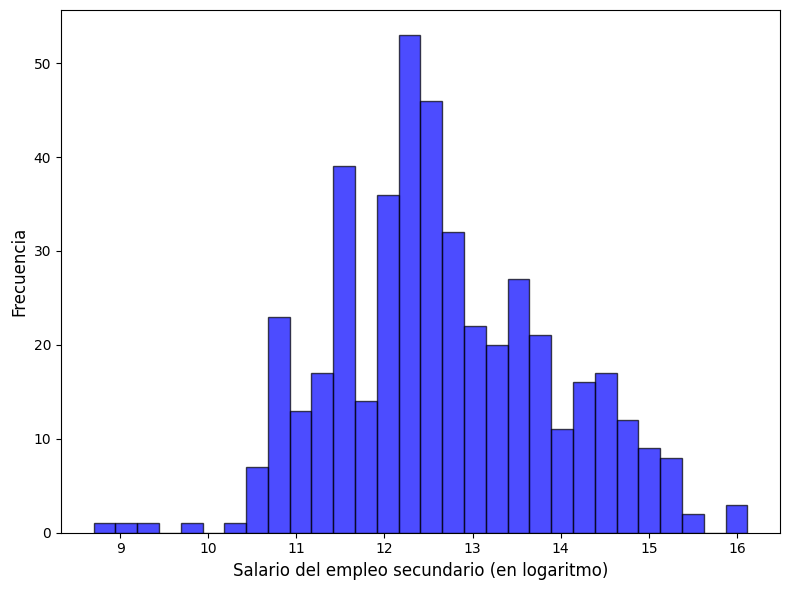

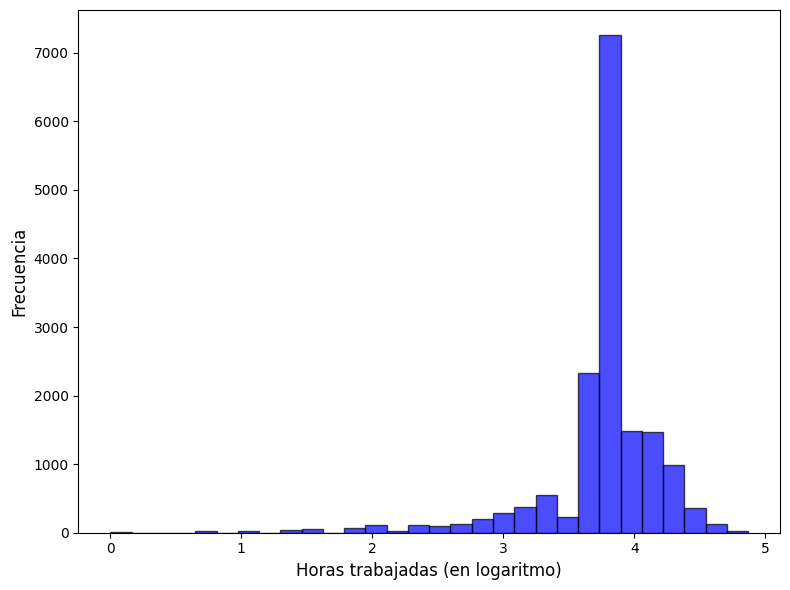

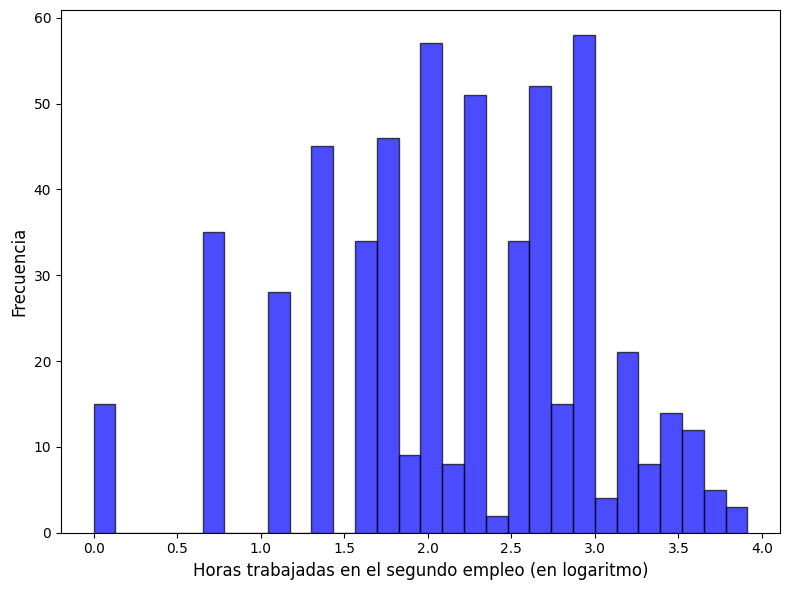

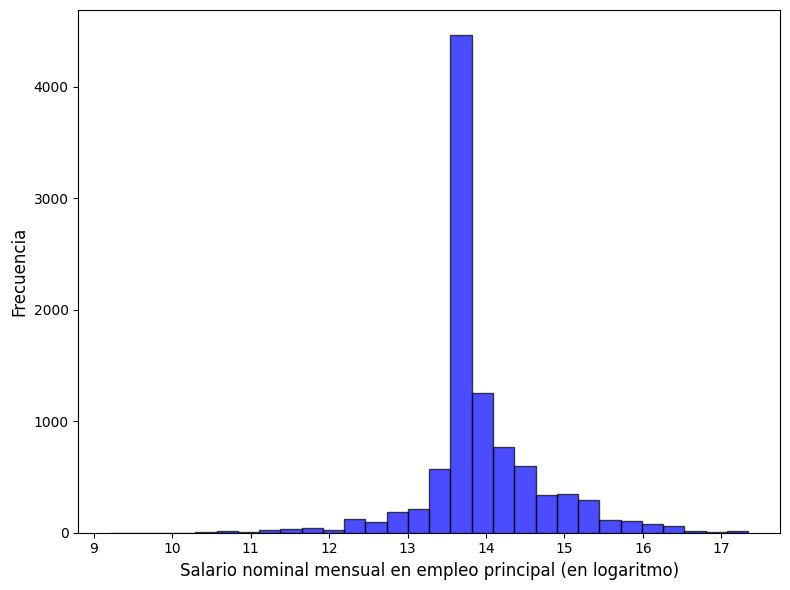

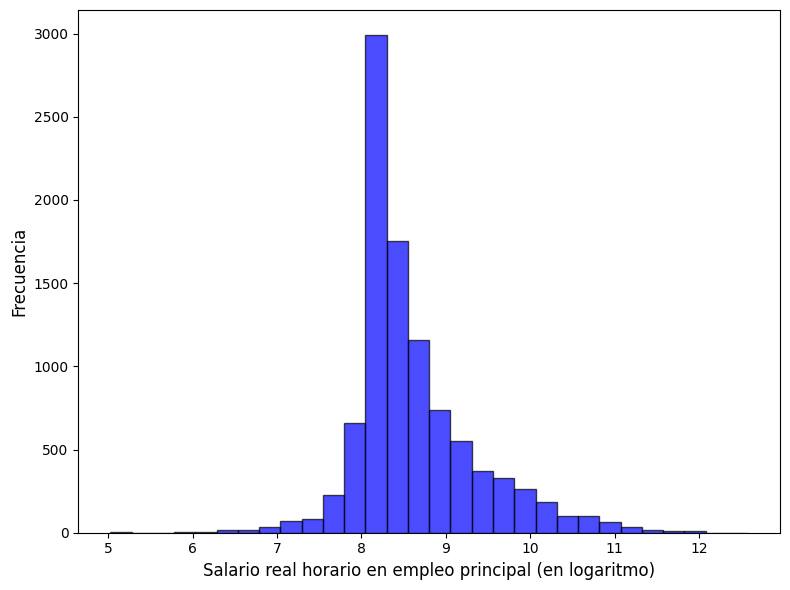

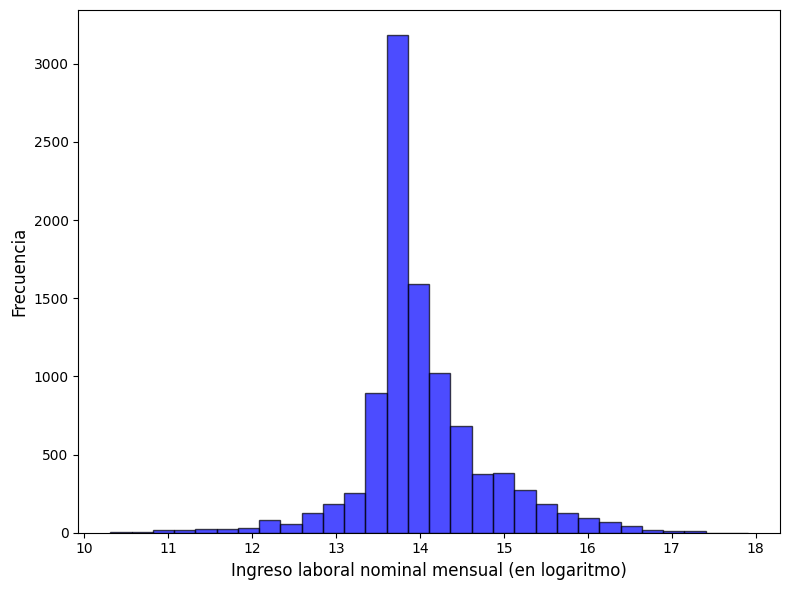

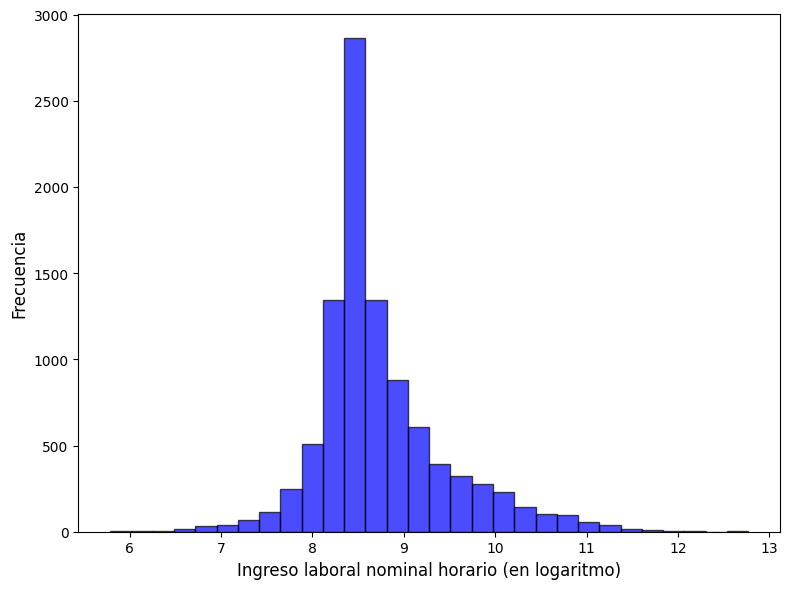

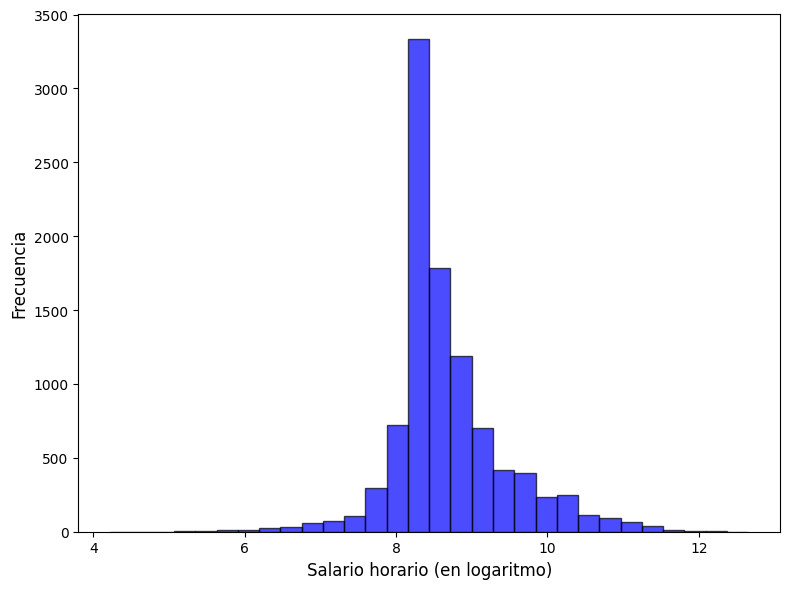

In [34]:
# Graficamos histogramas del logaritmo natural
for col in wage_hours_related_vars:
    data = df_limpio[col].dropna()

    # Excluimos valores no positivos para calcular logaritmo natural
    data_log = data[data > 0].apply(np.log)

    plt.figure(figsize=(8, 6))  # Tamaño de la figura
    plt.hist(data_log, bins=30, color='b', edgecolor='black', alpha=0.7)  # Color azul con bordes negros
    plt.xlabel(f"{etiquetas.get(col, col)} (en logaritmo)", fontsize=12)  # Etiqueta del eje x
    plt.ylabel("Frecuencia", fontsize=12)  # Etiqueta del eje y
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajusta los márgenes automáticamente
    plt.show()

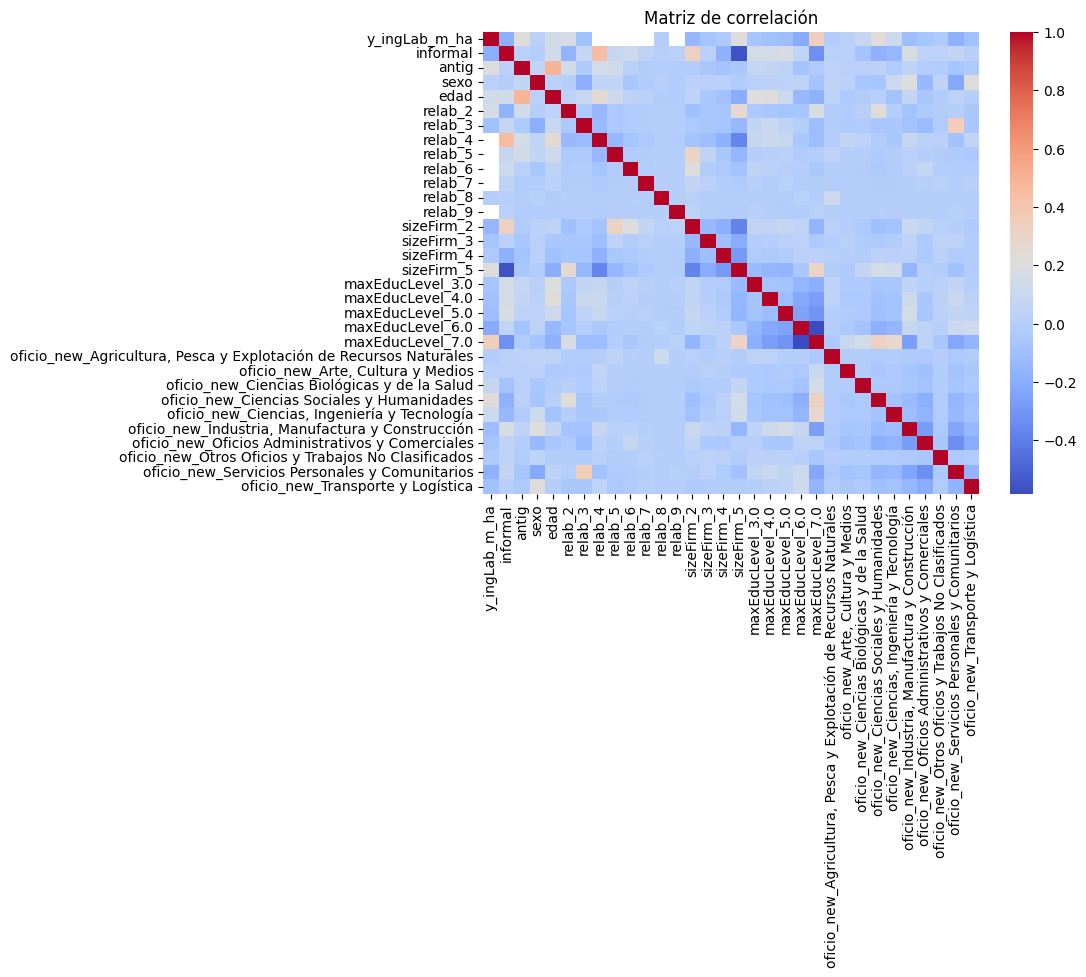

In [35]:
# Calculamos y visualizamos la matriz de correlación
corr_matrix = subset.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de correlación")
plt.show()

In [36]:
# Eliminamos missings

df_limpio = df_limpio[["y_ingLab_m_ha", "edad", "informal", "antig", "relab", "sexo", "sizeFirm","maxEducLevel", "oficio_new"]]
df_limpio = df_limpio.dropna()

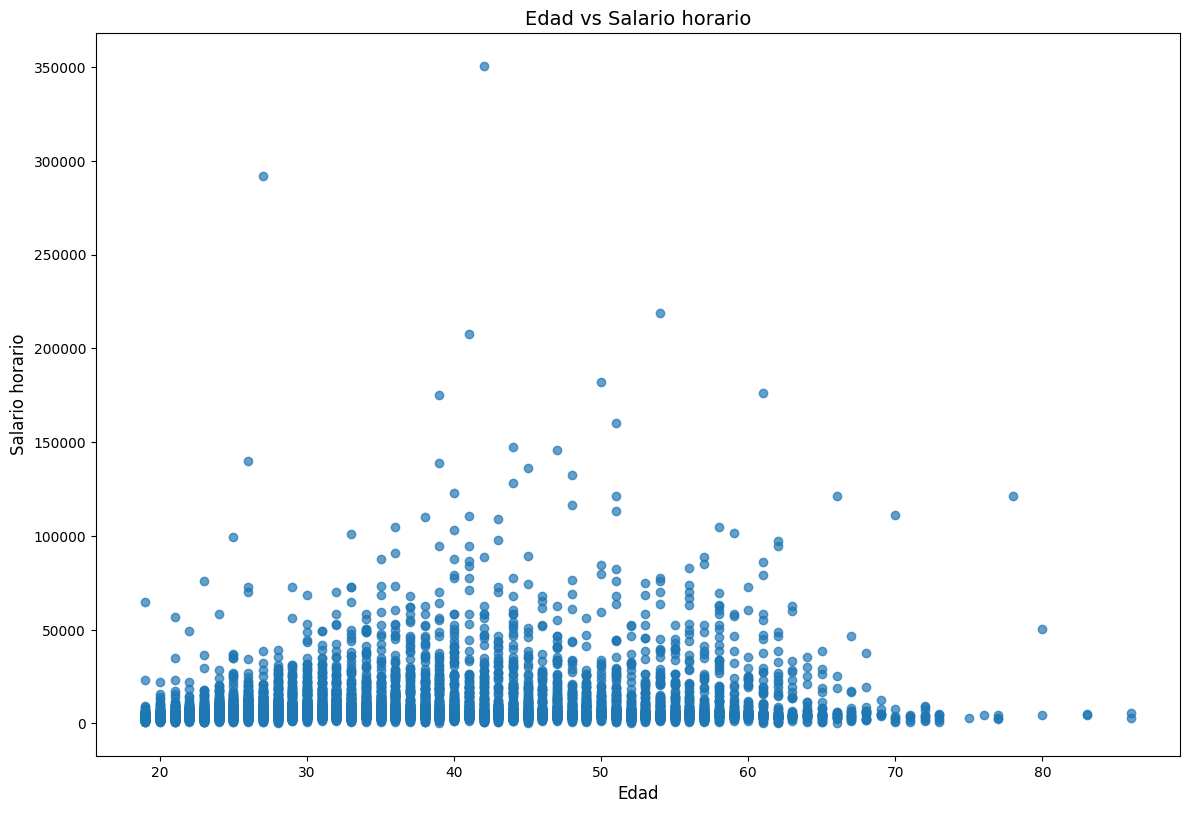

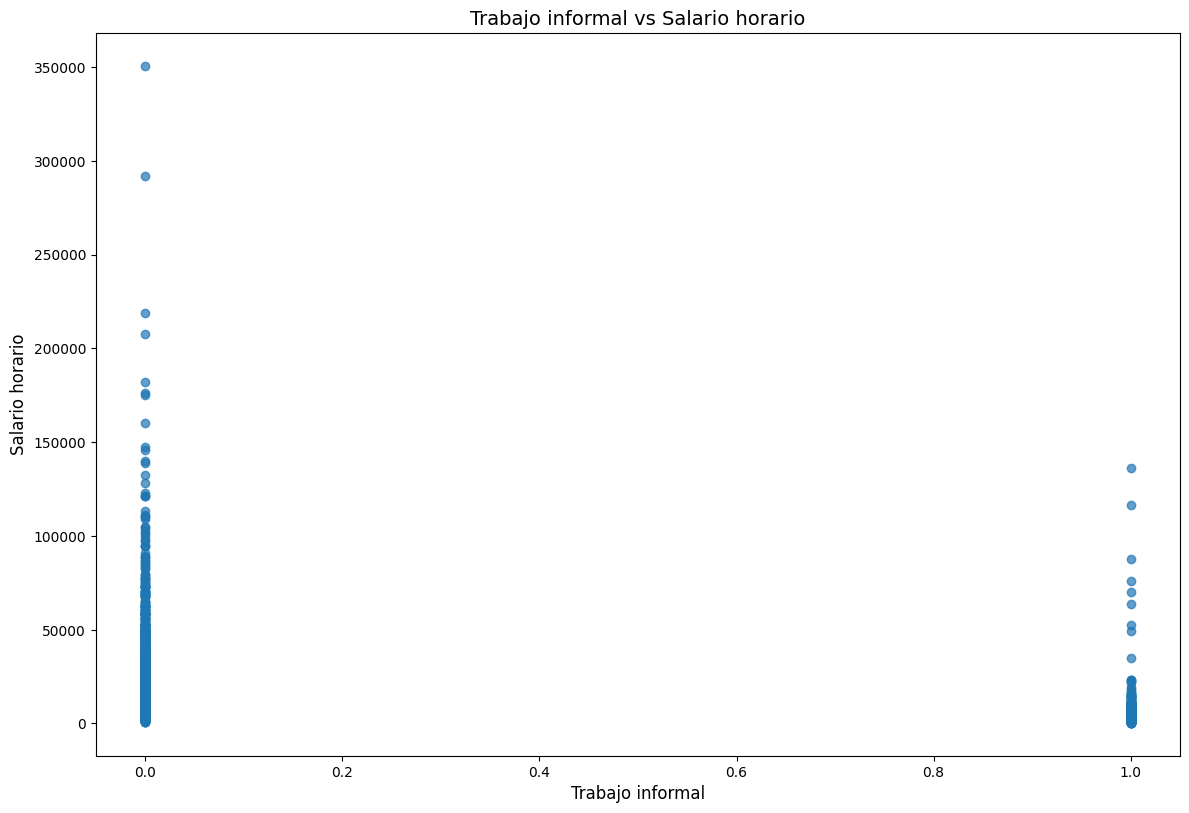

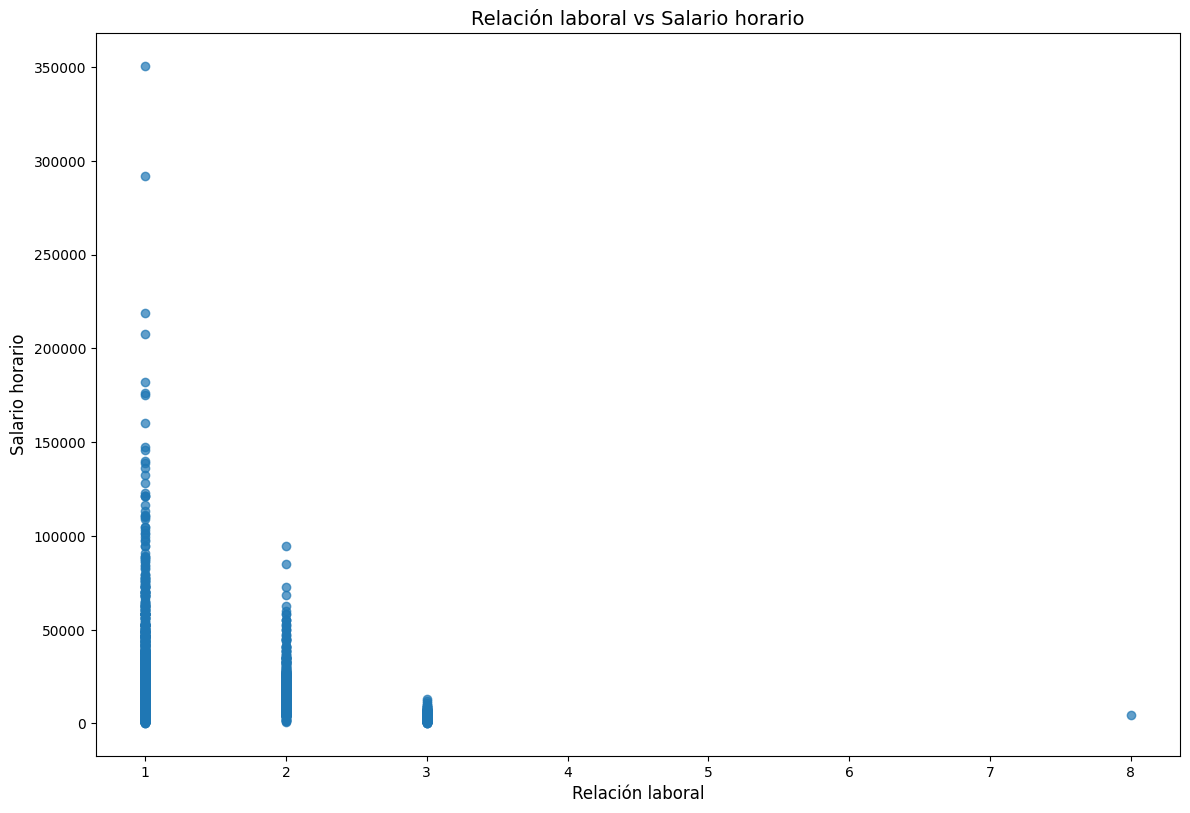

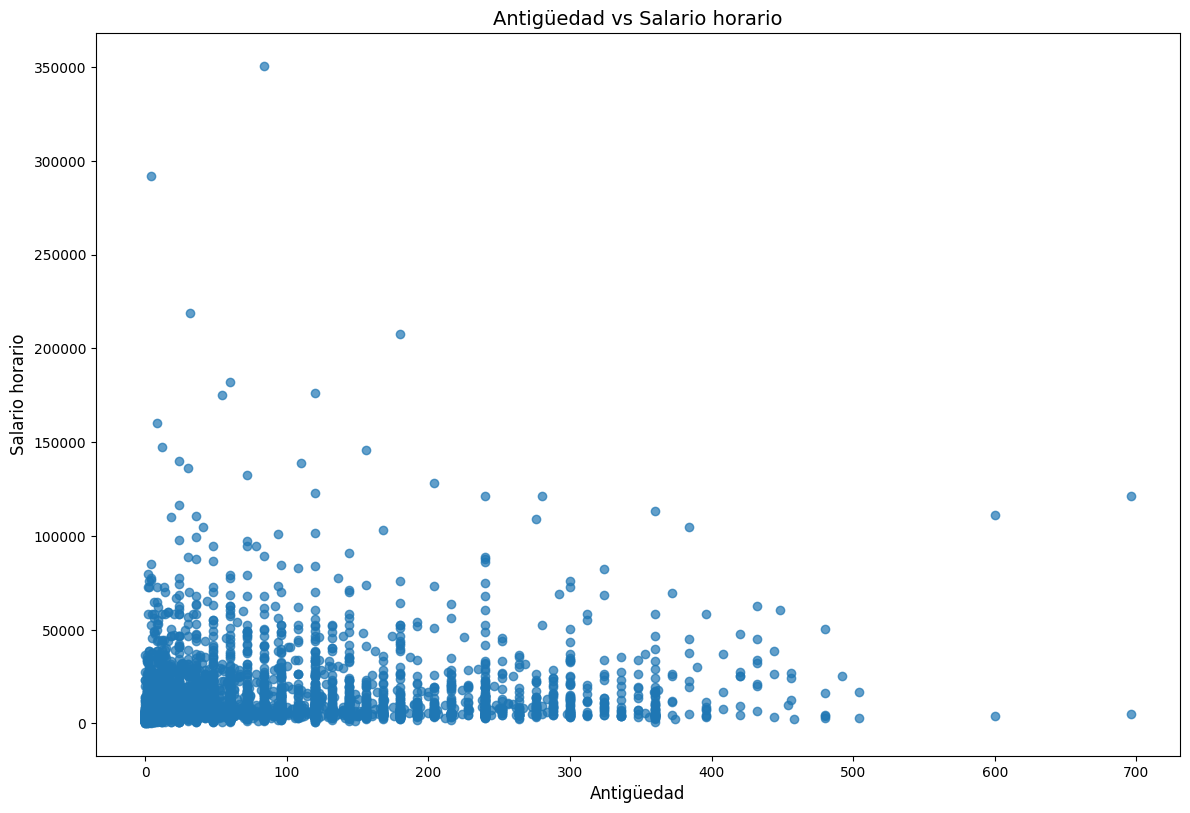

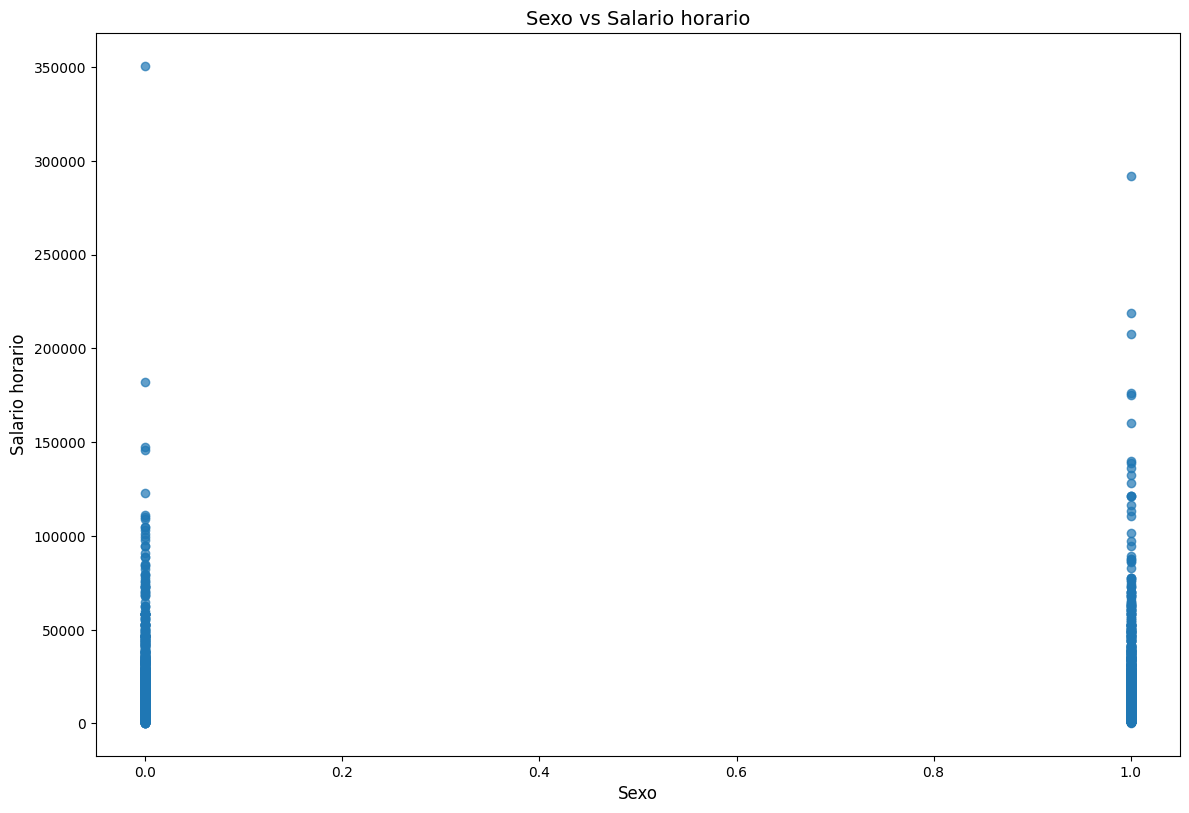

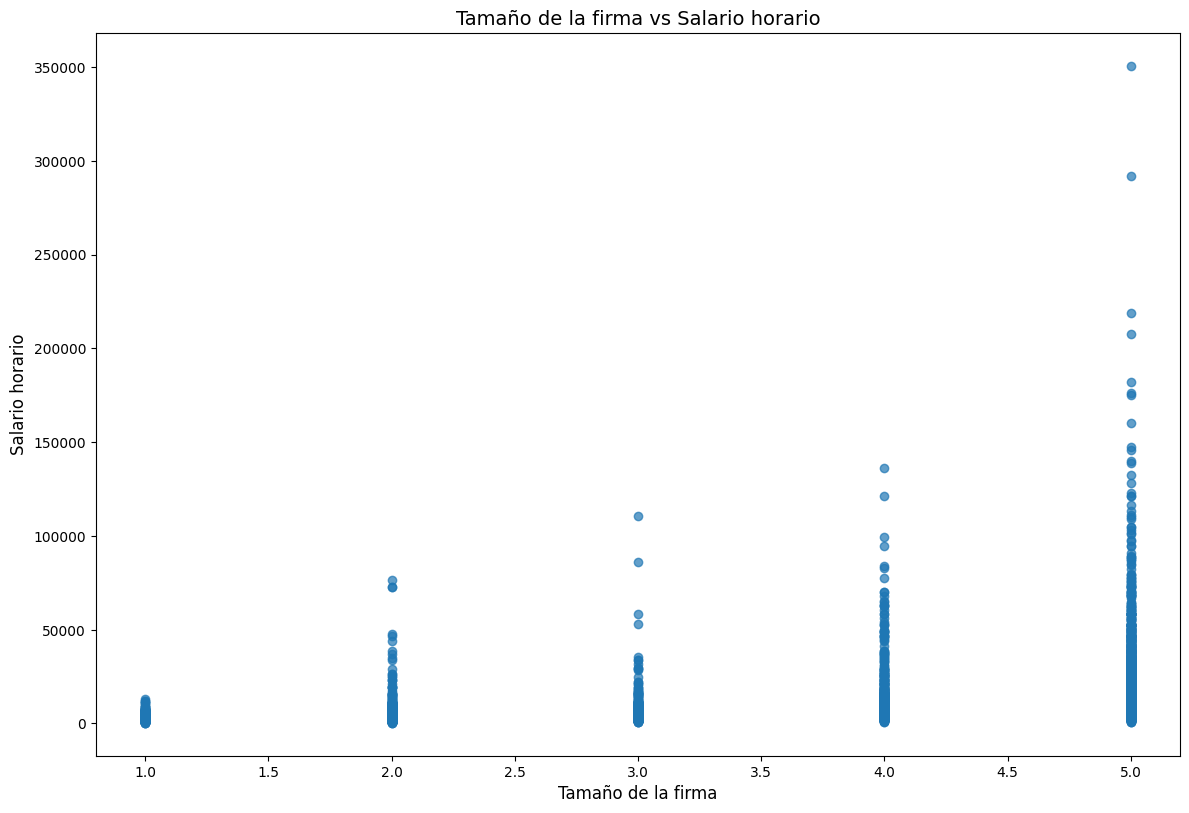

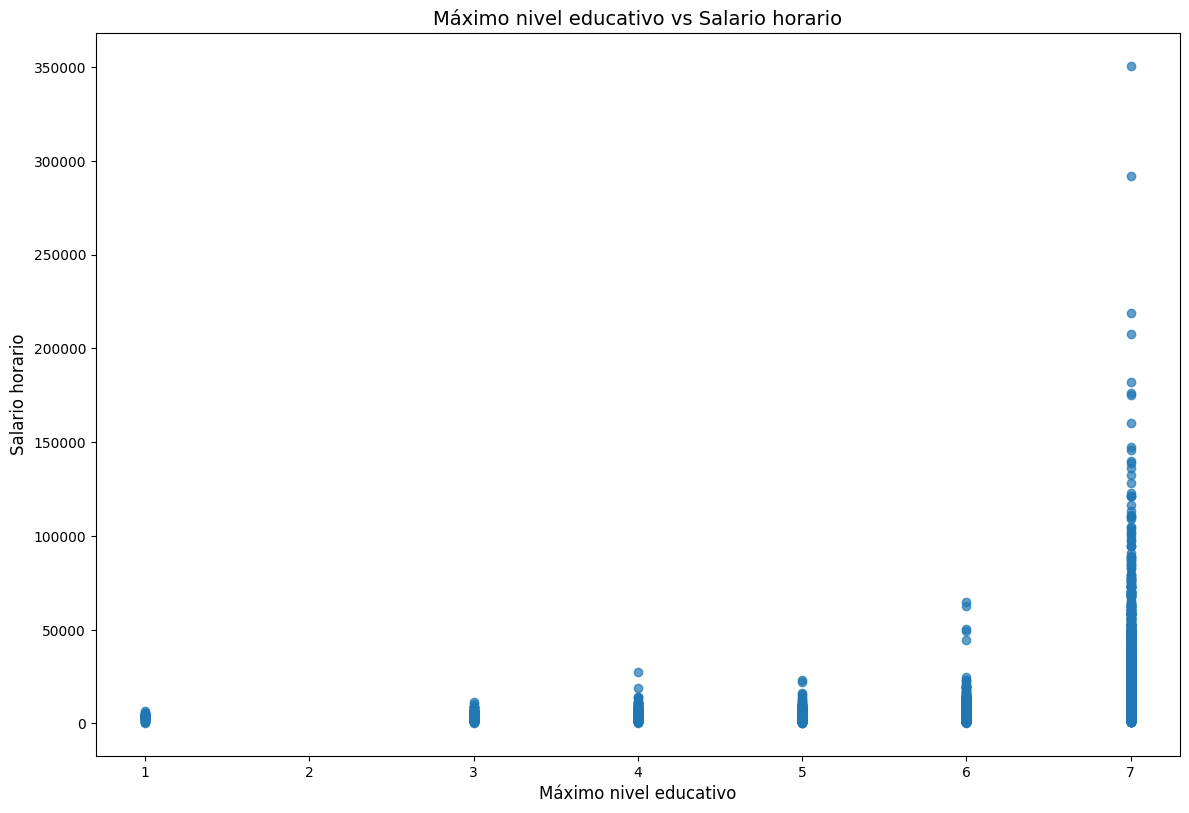

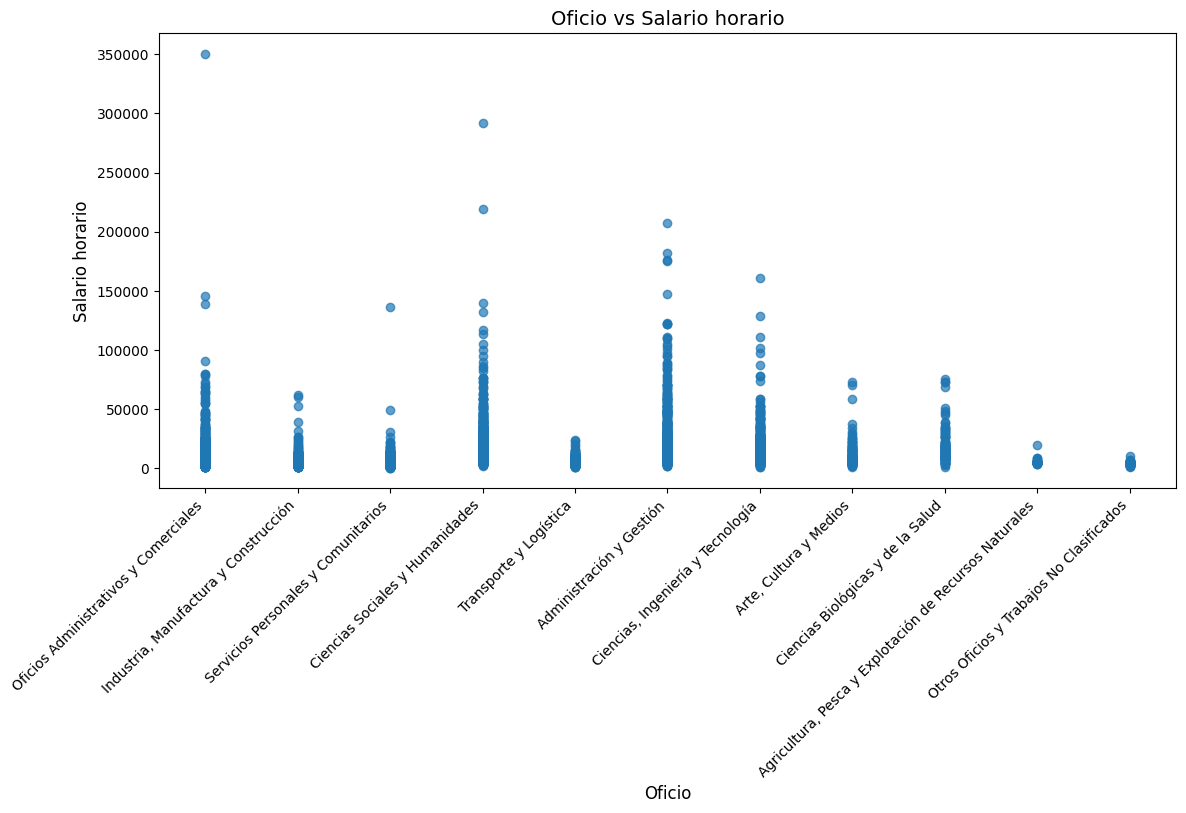

In [39]:
# Definimos las variables independientes y la dependiente
variables_independientes = ["edad", "informal", "relab", "antig", "sexo", "sizeFirm","maxEducLevel", "oficio_new"]

variable_dependiente = "y_ingLab_m_ha"

import matplotlib.pyplot as plt

# Diccionario para renombrar variables con nombres más descriptivos
etiquetas = {
    "edad": "Edad",
    "informal": "Trabajo informal",
    "relab": "Relación laboral",
    "antig": "Antigüedad",
    "sexo": "Sexo",
    "sizeFirm": "Tamaño de la firma",
    "maxEducLevel": "Máximo nivel educativo",
    "oficio_new": "Oficio",
    "y_ingLab_m_ha": "Salario horario"
}

# Creamos scatterplots entre la variable dependiente y cada variable independiente

for var in variables_independientes:
    plt.figure(figsize=(12, 8))  # Aumentar tamaño de la figura
    plt.scatter(df_limpio[var], df_limpio[variable_dependiente], alpha=0.7)
    plt.xlabel(etiquetas.get(var, var), fontsize=12)
    plt.ylabel(etiquetas[variable_dependiente], fontsize=12)
    if var == "oficio_new":  # Ajustes específicos para la variable categórica "oficio_new"
        plt.xticks(rotation=45, fontsize=10, ha="right")  # Rotar las etiquetas
    else:
        plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajustar diseño
    plt.title(f"{etiquetas.get(var, var)} vs {etiquetas[variable_dependiente]}", fontsize=14)
    plt.show()



# Modelos

In [ ]:
subset = subset.dropna()

In [ ]:
# Definimos variables dependiente e independientes, el train set y el test set

target = "y_ingLab_m_ha"

X = subset.drop(columns=[target])
y = np.log(subset[target])

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=0.3,
                                        train_size=0.7,
                                        random_state = 123
                                        )

X_train.head()

,informal,antig,sexo,edad,relab_2,relab_3,relab_4,relab_5,relab_6,relab_7,...,"oficio_new_Agricultura, Pesca y Explotación de Recursos Naturales","oficio_new_Arte, Cultura y Medios",oficio_new_Ciencias Biológicas y de la Salud,oficio_new_Ciencias Sociales y Humanidades,"oficio_new_Ciencias, Ingeniería y Tecnología","oficio_new_Industria, Manufactura y Construcción",oficio_new_Oficios Administrativos y Comerciales,oficio_new_Otros Oficios y Trabajos No Clasificados,oficio_new_Servicios Personales y Comunitarios,oficio_new_Transporte y Logística
7741,0,24,1,43,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
22475,0,144,1,32,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
13596,1,3,0,19,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
31707,0,7,0,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
15334,1,1,1,19,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Print the list of new columns
print(X_train.columns)

Index(['informal', 'antig', 'sexo', 'edad', 'relab_2', 'relab_3', 'relab_4',
       'relab_5', 'relab_6', 'relab_7', 'relab_8', 'relab_9', 'sizeFirm_2',
       'sizeFirm_3', 'sizeFirm_4', 'sizeFirm_5', 'maxEducLevel_3.0',
       'maxEducLevel_4.0', 'maxEducLevel_5.0', 'maxEducLevel_6.0',
       'maxEducLevel_7.0',
       'oficio_new_Agricultura, Pesca y Explotación de Recursos Naturales',
       'oficio_new_Arte, Cultura y Medios',
       'oficio_new_Ciencias Biológicas y de la Salud',
       'oficio_new_Ciencias Sociales y Humanidades',
       'oficio_new_Ciencias, Ingeniería y Tecnología',
       'oficio_new_Industria, Manufactura y Construcción',
       'oficio_new_Oficios Administrativos y Comerciales',
       'oficio_new_Otros Oficios y Trabajos No Clasificados',
       'oficio_new_Servicios Personales y Comunitarios',
       'oficio_new_Transporte y Logística'],
      dtype='object')


In [ ]:
def get_related_columns(df, categorical_vars):
    """
    Get all columns in a DataFrame related to specific categorical variables.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummy variables.
        categorical_vars (list): A list of prefixes for the categorical variables.

    Returns:
        dict: A dictionary where keys are the variable prefixes and values are lists of column names.
    """
    related_columns = {}
    for var in categorical_vars:
        # Encuentro a todas las variables relacionadas con la variable categórica
        related_columns[var] = [col for col in df.columns if var in col]
    return related_columns

# Lista de variables categóricas
categorical_vars = ["relab", "sizeFirm", "maxEducLevel", "oficio_new"]

related_columns_dict = get_related_columns(X_train, categorical_vars)

for var, columns in related_columns_dict.items():
    print(f"{var}: {columns}")


relab: ['relab_2', 'relab_3', 'relab_4', 'relab_5', 'relab_6', 'relab_7', 'relab_8', 'relab_9']
sizeFirm: ['sizeFirm_2', 'sizeFirm_3', 'sizeFirm_4', 'sizeFirm_5']
maxEducLevel: ['maxEducLevel_3.0', 'maxEducLevel_4.0', 'maxEducLevel_5.0', 'maxEducLevel_6.0', 'maxEducLevel_7.0']
oficio_new: ['oficio_new_Agricultura, Pesca y Explotación de Recursos Naturales', 'oficio_new_Arte, Cultura y Medios', 'oficio_new_Ciencias Biológicas y de la Salud', 'oficio_new_Ciencias Sociales y Humanidades', 'oficio_new_Ciencias, Ingeniería y Tecnología', 'oficio_new_Industria, Manufactura y Construcción', 'oficio_new_Oficios Administrativos y Comerciales', 'oficio_new_Otros Oficios y Trabajos No Clasificados', 'oficio_new_Servicios Personales y Comunitarios', 'oficio_new_Transporte y Logística']


## Modelo 1

In [ ]:
# Definimos el modelo
X0 = np.ones((len(y_train), 1))
model1= LinearRegression().fit(X0,y_train)
model1.intercept_

8.738219300106667

In [ ]:
# Media estimada
y_train.mean()

8.738219300106667

In [ ]:
# Predicciones basadas en el modelo 1
X0_test = np.ones((len(y_test), 1))
y_hat_model1 = model1.predict(X0_test)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse1 = mean_squared_error(y_test, y_hat_model1)
rmse1 = np.sqrt(mse1)

print(f'Root Mean Squared Error: {rmse1}')

Root Mean Squared Error: 0.7279530339569263


## Modelo 2: Intercepto y máximo nivel educativo alcanzado

In [ ]:
# Agarramos las dummies relevantes, en este caso las de nivel educativo
columns_to_use_2 = related_columns_dict["maxEducLevel"]

In [ ]:
# Definimos el modelo
model2=  LinearRegression().fit(X_train[columns_to_use_2],y_train)
model2.coef_

array([0.31051453, 0.36232047, 0.35244773, 0.46124657, 1.13854453])

In [ ]:
# Predicciones basadas en el modelo 2
y_hat_model2 = model2.predict(X_test[columns_to_use_2])

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse2 = mean_squared_error(y_test, y_hat_model2)
rmse2 = np.sqrt(mse2)

print(f'Root Mean Squared Error: {rmse2}')

Root Mean Squared Error: 0.6234072299526698


## Modelo 3: Intercepto, máximo nivel educativo alcanzado, edad y sexo

In [ ]:
# Definimos el modelo
model3=  LinearRegression().fit(X_train[["edad", "informal","sexo"]+columns_to_use_2],y_train)
model3.coef_

array([ 0.01357905, -0.46824236,  0.10934165,  0.25686295,  0.27719788,
        0.3519472 ,  0.48156595,  1.10302817])

In [ ]:
# Predicciones basadas en el modelo 3
y_hat_model3 = model3.predict(X_test[["edad", "informal","sexo"]+columns_to_use_2])

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse3 = mean_squared_error(y_test, y_hat_model3)
rmse3 = np.sqrt(mse3)

print(f'Root Mean Squared Error: {rmse3}')

Root Mean Squared Error: 0.5660692283692504


## Modelo 4: Intercepto, máximo nivel educativo alcanzado, edad, sexo, formalidad del empleo y tipo de relación laboral

In [ ]:
# Agarramos las dummies relevantes, en este caso las de nivel educativo y relación laboral
columns_to_use_4 = related_columns_dict["relab"] + related_columns_dict["maxEducLevel"]

In [ ]:
# Defino el modelo
model4=  LinearRegression().fit(X_train[["edad", "informal", "sexo"]+columns_to_use_4],y_train)
model4.coef_

array([ 1.27628576e-02, -4.39722075e-01,  8.48975852e-02,  3.80879694e-01,
       -1.70341469e-01, -1.13797860e-15, -6.10622664e-16,  0.00000000e+00,
        2.77555756e-17,  0.00000000e+00,  0.00000000e+00,  2.24920009e-01,
        2.45533891e-01,  3.03486054e-01,  4.11790085e-01,  9.97516731e-01])

In [ ]:
# Predicciones basadas en el modelo 4
y_hat_model4 = model4.predict(X_test[["edad", "informal", "sexo"]+columns_to_use_4])

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse4 = mean_squared_error(y_test, y_hat_model4)
rmse4 = np.sqrt(mse4)

print(f'Root Mean Squared Error: {rmse4}')

Root Mean Squared Error: 0.5572456941008624


## Modelo 5: Intercepto, máximo nivel educativo alcanzado, edad, sexo, formalidad del empleo, tipo de relación laboral, antiguedad y tamaño de la firma

In [ ]:
# Agarramos las dummies relevantes, en este caso las de nivel educativo y relación laboral
columns_to_use_5 = related_columns_dict["relab"] + related_columns_dict["maxEducLevel"] + related_columns_dict["sizeFirm"]

In [ ]:
# Defino el modelo
model5=  LinearRegression().fit(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_5],y_train)
model5.coef_

array([ 9.56143662e-03, -2.72898845e-01,  1.20675952e-03,  8.16924615e-02,
        2.72092807e-01,  8.91827317e-02,  5.55111512e-17, -8.32667268e-17,
        5.55111512e-16,  3.33066907e-16, -2.22044605e-16,  6.93889390e-17,
        2.57503625e-01,  2.76679344e-01,  3.24669869e-01,  4.09559739e-01,
        9.65766946e-01,  1.42908822e-01,  2.58736499e-01,  3.19840062e-01,
        4.28196843e-01])

In [ ]:
# Predicciones basadas en el modelo 5
y_hat_model5 = model5.predict(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_5])

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse5 = mean_squared_error(y_test, y_hat_model5)
rmse5 = np.sqrt(mse5)

print(f'Root Mean Squared Error: {rmse5}')

Root Mean Squared Error: 0.544879625977407


## Modelo 6: Intercepto, máximo nivel educativo alcanzado, edad, sexo, formalidad del empleo, tipo de relación laboral, antiguedad, tamaño de la firma y oficio



In [ ]:
# Agarramos las dummies relevantes, en este caso las de nivel educativo, relación laboral y oficio
columns_to_use_6 = related_columns_dict["relab"] + related_columns_dict["maxEducLevel"] + related_columns_dict["sizeFirm"] + related_columns_dict["oficio_new"]

In [ ]:
# Defino el modelo
model6=  LinearRegression().fit(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_6],y_train)
model6.coef_

array([ 7.49073812e-03, -2.41391127e-01,  1.00274101e-03,  9.02539072e-02,
        2.46209660e-01,  1.88535543e-01,  2.99760217e-15, -1.11022302e-15,
        1.77635684e-15, -4.44089210e-16,  4.77395901e-15, -3.33066907e-16,
        2.48782237e-01,  2.66312664e-01,  3.09224079e-01,  3.63162135e-01,
        6.56717664e-01,  1.59941811e-01,  2.58870910e-01,  3.07262527e-01,
        4.30178387e-01, -9.12226428e-01, -4.70811259e-01, -2.14493461e-01,
       -3.04562515e-01, -5.10440804e-01, -8.76063030e-01, -8.25182057e-01,
       -1.05287457e+00, -9.39040110e-01, -9.64758920e-01])

In [ ]:
# Predicciones basadas en el modelo 6
y_hat_model6 = model6.predict(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_6])

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse6 = mean_squared_error(y_test, y_hat_model6)
rmse6 = np.sqrt(mse6)

print(f'Root Mean Squared Error: {rmse6}')

Root Mean Squared Error: 0.4983515263900513


## Modelo 7: Modelo 3 con interacciones y no linealidades de segundo grado

In [ ]:
poly_2 = PolynomialFeatures(degree=2)

In [ ]:
poly_3 = PolynomialFeatures(degree=3)

In [ ]:
# Defino el modelo
X_train_poly_2 = poly_2.fit_transform(X_train[["edad","informal","sexo"]+columns_to_use_2])
model7 =  LinearRegression().fit(X_train_poly_2,y_train)

In [ ]:
# Predicciones basadas en el modelo 7
X_test_poly_7 = poly_2.fit_transform(X_test[["edad", "informal","sexo"]+columns_to_use_2])
y_hat_model7 = model7.predict(X_test_poly_7)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse7 = mean_squared_error(y_test, y_hat_model7)
rmse7 = np.sqrt(mse7)

print(f'Root Mean Squared Error: {rmse7}')

Root Mean Squared Error: 0.5415361994218543


## Modelo 8: Modelo 3 con interacciones y no linealidades de tercer grado

In [ ]:
# Defino el modelo
X_train_poly_3 = poly_3.fit_transform(X_train[["edad","informal","sexo"]+columns_to_use_2])
model8 =  LinearRegression().fit(X_train_poly_3,y_train)

In [ ]:
# Predicciones basadas en el modelo 8
X_test_poly_8 = poly_3.fit_transform(X_test[["edad", "informal","sexo"]+columns_to_use_2])
y_hat_model8 = model8.predict(X_test_poly_8)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse8 = mean_squared_error(y_test, y_hat_model8)
rmse8 = np.sqrt(mse8)

print(f'Root Mean Squared Error: {rmse8}')

Root Mean Squared Error: 0.5388156440820212


## Modelo 9: Modelo 4 con interacciones y no linealidades de segundo grado

In [ ]:
# Defino el modelo
X_train_poly_2 = poly_2.fit_transform(X_train[["edad", "informal", "sexo"]+columns_to_use_4])
model9 =  LinearRegression().fit(X_train_poly_2,y_train)

In [ ]:
# Predicciones basadas en el modelo 9
X_test_poly_9 = poly_2.fit_transform(X_test[["edad", "informal", "sexo"]+columns_to_use_4])
y_hat_model9 = model9.predict(X_test_poly_9)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse9 = mean_squared_error(y_test, y_hat_model9)
rmse9 = np.sqrt(mse9)

print(f'Root Mean Squared Error: {rmse9}')

Root Mean Squared Error: 0.5334205104501608


## Modelo 10: Modelo 4 con interacciones y no linealidades de tercer grado

In [ ]:
# Defino el modelo
X_train_poly_3 = poly_3.fit_transform(X_train[["edad", "informal", "sexo"]+columns_to_use_4])
model10 =  LinearRegression().fit(X_train_poly_3,y_train)

In [ ]:
# Predicciones basadas en el modelo 10
X_test_poly_10 = poly_3.fit_transform(X_test[["edad", "informal", "sexo"]+columns_to_use_4])
y_hat_model10 = model10.predict(X_test_poly_10)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse10 = mean_squared_error(y_test, y_hat_model10)
rmse10 = np.sqrt(mse10)

print(f'Mean Squared Error: {rmse10}')

Mean Squared Error: 0.5309793948954556


## Modelo 11: Modelo 5 con interacciones y no linealidades de segundo grado



In [ ]:
# Defino el modelo
X_train_poly_2 = poly_2.fit_transform(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_5])
model11 =  LinearRegression().fit(X_train_poly_2,y_train)

In [ ]:
# Predicciones basadas en el modelo 11
X_test_poly_11 = poly_2.fit_transform(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_5])
y_hat_model11 = model11.predict(X_test_poly_11)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse11 = mean_squared_error(y_test, y_hat_model11)
rmse11 = np.sqrt(mse11)

print(f'Mean Squared Error: {rmse11}')

Mean Squared Error: 0.5196625813384844


## Modelo 12: Modelo 5 con interacciones y no linealidades de tercer grado


In [ ]:
# Defino el modelo
X_train_poly_3 = poly_3.fit_transform(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_5])
model12 =  LinearRegression().fit(X_train_poly_3,y_train)

In [ ]:
# Predicciones basadas en el modelo 12
X_test_poly_12 = poly_3.fit_transform(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_5])
y_hat_model12 = model12.predict(X_test_poly_12)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse12 = mean_squared_error(y_test, y_hat_model12)
rmse12 = np.sqrt(mse12)

print(f'Mean Squared Error: {rmse12}')

Mean Squared Error: 0.5526360727028169


## Modelo 13: Modelo 6 con interacciones y no linealidades de segundo grado



In [ ]:
# Defino el modelo
X_train_poly_2 = poly_2.fit_transform(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_6])
model13 =  LinearRegression().fit(X_train_poly_2,y_train)

In [ ]:
# Predicciones basadas en el modelo 13
X_test_poly_13 = poly_2.fit_transform(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_6])
y_hat_model13 = model13.predict(X_test_poly_13)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse13 = mean_squared_error(y_test, y_hat_model13)
rmse13 = np.sqrt(mse13)

print(f'Mean Squared Error: {rmse13}')

Mean Squared Error: 0.4861149349300927


## Modelo 14: Modelo 6 con interacciones y no linealidades de tercer grado


In [ ]:
# Defino el modelo
X_train_poly_3 = poly_3.fit_transform(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_6])
model14 =  LinearRegression().fit(X_train_poly_3,y_train)

In [ ]:
# Predicciones basadas en el modelo 14
X_test_poly_14 = poly_3.fit_transform(X_test[["edad", "informal", "antig", "sexo"]+columns_to_use_6])
y_hat_model14 = model14.predict(X_test_poly_14)

# Calculamos el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse14 = mean_squared_error(y_test, y_hat_model14)
rmse14 = np.sqrt(mse14)

print(f'Mean Squared Error: {rmse14}')

## Resumen en DF

In [ ]:
# Lista de nombres de los modelos
model_names = [
    "Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4",
    "Modelo 5", "Modelo 6", "Modelo 7", "Modelo 8",
    "Modelo 9", "Modelo 10", "Modelo 11", "Modelo 12",
    "Modelo 13", "Modelo 14"
]

# Lista de los MSE calculados
mse_values = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8, rmse9, rmse10, rmse11, rmse12, rmse13, rmse14]

# Crear un DataFrame con los resultados
mse_df = pd.DataFrame({
    "Modelo": model_names,
    "MSE": mse_values
})

# Mostrar la tabla
print(mse_df)

# Errores de los modelos 1 y 14

In [ ]:
# Defino modelos
models = [
    ("Modelo 1", y_hat_model1),
    ("Modelo 14", y_hat_model14)
]

# Grafico distribución de los errores
for name, y_hat in models:
    # Calcular los errores
    residuals = y_test - y_hat.flatten()

    # Graficar la distribución de los errores
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, alpha=0.7)
    plt.title(f"Distribución de los Errores - {name}", fontsize=16)
    plt.xlabel("Errores", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Modelo 1

# Graficar valores reales vs predicciones
plt.figure(figsize=(8, 6))  # Tamaño de la figura
plt.scatter(range(len(y_test)), y_test, label='Valores reales', alpha=0.6)
plt.plot(range(len(y_test)), y_hat_model1, color='red', label='Predicciones', alpha=0.7, linestyle='-', linewidth=2)
plt.title("Valores Reales vs Predicciones - Modelo 1", fontsize=16)
plt.xlabel("Observación", fontsize=14)
plt.ylabel("Salario Horario", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Ajusta el diseño
plt.show()

# Guardo el plot como PNG file
plt.savefig(f"{folder_path_views}modelo1_residuals_scatterplot.png", dpi=300)
plt.close()

!git add .
!git commit -m "Add exported chart"
!git push origin main

# Modelo 14

# Graficar valores reales vs predicciones
plt.figure(figsize=(8, 6))  # Tamaño de la figura
plt.scatter(range(len(y_test)), y_test, label='Valores reales', alpha=0.6)
plt.scatter(range(len(y_test)), y_hat_model14, color='red', label='Predicciones', alpha=0.7, linestyle='-', linewidth=2)
plt.title("Valores Reales vs Predicciones - Modelo 14", fontsize=16)
plt.xlabel("Observación", fontsize=14)
plt.ylabel("Salario Horario", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Ajusta el diseño
plt.show()


In [ ]:
# Definir el Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()

# Para Modelo 1 (solo el intercepto)
mse1_list = []

for train_index, test_index in loo.split(X_train):
    X_train_loo, X_test_loo = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_loo, y_test_loo = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entrenar el modelo
    model1 = LinearRegression().fit(np.ones((len(X_train_loo), 1)), y_train_loo)

    # Predecir
    y_hat_model1 = model1.predict(np.ones((len(X_test_loo), 1)))

    # Calcular el MSE
    mse1_list.append(mean_squared_error(y_test_loo, y_hat_model1))

# Promedio de MSE para el modelo 1
mse1_loo = np.mean(mse1_list)
print(f'Mean Squared Error para Modelo 1 (LOOCV): {mse1_loo}')

# Para Modelo 14
mse14_list = []

for train_index, test_index in loo.split(X_train[["edad", "informal", "antig", "sexo"]+columns_to_use_6]):
    X_train_loo, X_test_loo = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_loo, y_test_loo = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entrenar el modelo
    model14 = LinearRegression().fit(X_train_loo[["edad", "informal", "antig", "sexo"]+columns_to_use_6], y_train_loo)

    # Predecir
    y_hat_model14 = model14.predict(X_test_loo[["edad", "informal", "antig", "sexo"]+columns_to_use_6])

    # Calcular el MSE
    mse14_list.append(mean_squared_error(y_test_loo, y_hat_model14))

# Promedio de MSE para el modelo 14
mse14_loo = np.mean(mse14_list)
print(f'Mean Squared Error para Modelo 14 (LOOCV): {mse14_loo}')
